## Transfomer-based Encoder Decoder with Pretrained Dense121+CheXNet Weights

#### 1. Importing Libraries and Configuring the Session

In [1]:
#!pip install nltk

In [2]:
import tensorflow as tf
import random
from collections import Counter
import os
import warnings
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import nltk
from keras.layers import TextVectorization
import keras
from keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Reshape, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

2024-05-03 12:05:09.739833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 12:05:10.737166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/opt/conda/lib
2024-05-03 12:05:10.737290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/lo

In [3]:
def configure_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s) configured.")
        except RuntimeError as e:
            print(f"RuntimeError in configuring GPUs: {e}")
    else:
        print("No GPU is available.")

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def check_jupyter_notebook():
    try:
        cfg = get_ipython().config 
        print("Jupyter Notebook environment detected. Configuring...")
        cfg.NotebookApp.iopub_msg_rate_limit = 10000.0
        cfg.NotebookApp.rate_limit_window = 5.0
    except NameError:
        print("Not running in a Jupyter Notebook environment.")

# Clear TensorFlow session and suppress warnings
tf.keras.backend.clear_session()
warnings.filterwarnings("ignore")

# GPU configuration and seed setting
configure_gpus()
seed_everything()

# Check if running in Jupyter Notebook and configure
check_jupyter_notebook()

# Initialize TensorFlow distributed strategy
strategy = tf.distribute.MirroredStrategy()

2 Physical GPU(s), 2 Logical GPU(s) configured.
Jupyter Notebook environment detected. Configuring...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-05-03 12:05:12.094884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-03 12:05:12.095241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-03 12:05:12.125306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-03 12:05:12.125639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-03 12:05:12.125880: I tensorflow/compiler/xla/stream_executo

#### 2. Train, Test and Validation Data Preparation (Image Paths, Pre-processed Captions)

In [4]:
with strategy.scope():
    class CaptionDataProcessor:
        def __init__(self, train_csv, valid_csv, train_images_path, valid_images_path,test_image_path):
            self.train_csv = train_csv
            self.valid_csv = valid_csv
            self.train_images_path = train_images_path
            self.valid_images_path = valid_images_path
            self.test_images_path = test_image_path
            self.image_caption_pairs = {}
            self.caption_ls = []
            self.vocab_list = set()
            self.cap_len = []

        def load_data(self):
            df_train = pd.read_csv(self.train_csv, index_col=False)#, delimiter='\t',index=False)
            df_valid = pd.read_csv(self.valid_csv, index_col=False)#, delimiter='\t',index=False)
            self.process_data(df_train, self.train_images_path, "Training Image and Caption Data")
            self.process_data(df_valid, self.valid_images_path, "Validation Image and Caption Data")

        def process_caption(self, text):
            # Lowercase the caption label
            caption_labels_lower = text.lower()
            caption_labels_lower = caption_labels_lower.strip()

            # Replace hyphens with spaces
            caption_labels_clean = re.sub(r'-', ' ', caption_labels_lower)

            # Remove special characters using regular expressions
            caption_labels_clean = re.sub(r'[^a-zA-Z0-9\s]', '', caption_labels_clean)

            # Tokenize the caption label into words
            words = caption_labels_clean.split()

            # Remove numbers, words containing any numeric values
            processed_words = [word for word in words if not word.isdigit() and not any(char.isdigit() for char in word)]

            # Join the processed words back into a sentence
            caption_labels_processed = ' '.join(processed_words)
            caption_labels_processed = '<START> '+caption_labels_processed+ ' <END>'
            return caption_labels_processed

        def process_data(self, df, image_path_prefix, desc):
            for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=desc):
                #print(len(row))
                img_id, img_caption = row['ID'], row['Caption']
                img_path = os.path.join(image_path_prefix, str(img_id) + '.jpg')
                caption = self.process_caption(img_caption)

                if os.path.exists(img_path):
                    if img_path not in self.image_caption_pairs:
                        self.image_caption_pairs[img_path] = []

                    self.image_caption_pairs[img_path].append(caption)
                    self.caption_ls.append(caption)
                    self.vocab_list.update(caption.split(' '))
                    words = caption.split(' ')
                    self.cap_len.append(len(words))
                else:
                    print(f"File not found: {img_path}")



        def save_datasets(self, save_dir):
            """Saves the main dataset and the train, validation, and test splits to files."""
            try:
                os.makedirs(save_dir, exist_ok=True)
                self._save_dataset(os.path.join(save_dir, 'main_dataset.pkl'), self.image_caption_pairs)
                self._save_dataset(os.path.join(save_dir, 'train.pkl'), self.training_data)
                self._save_dataset(os.path.join(save_dir, 'valid.pkl'), self.validation_data)
                self._save_dataset(os.path.join(save_dir, 'test.pkl'), self.test_data)
                print("Datasets saved successfully.")
            except Exception as e:
                print(f"Error saving datasets: {e}")

        def _save_dataset(self, file_path, dataset):
            """Helper method to save a single dataset to a file."""
            with open(file_path, 'wb') as file:
                pickle.dump(dataset, file)
        
        
        
        def train_val_test_split(self, train_size=0.8, val_size=0.15, shuffle=True):
            all_images = list(self.image_caption_pairs.keys())
            if shuffle:
                np.random.shuffle(all_images)

            total_size = len(self.image_caption_pairs)
            train_end = int(total_size * train_size)
            val_end = train_end + int(total_size * val_size)

            # Properly set the class attributes for the splits
            self.training_data = {img_name: self.image_caption_pairs[img_name] for img_name in all_images[:train_end]}
            self.validation_data = {img_name: self.image_caption_pairs[img_name] for img_name in all_images[train_end:val_end]}
            self.test_data = {img_name: self.image_caption_pairs[img_name] for img_name in all_images[val_end:]}

            # Return the splits for external use as well
            return self.training_data, self.validation_data, self.test_data

    processor = CaptionDataProcessor(
        'train_captions.csv',
        'valid_captions.csv',
        '../Training/',
        '../Valid/',
        '../Test/'
    )
    processor.load_data()
    train_data, valid_data, test_data = processor.train_val_test_split()
    processor.save_datasets('pickles_clef24')

    print("Number of records in the main dataset: ", len(processor.image_caption_pairs))
    print("Number of training samples: ", len(train_data))
    print("Number of validation samples: ", len(valid_data))
    print("Number of test samples: ", len(test_data))

Validation Image and Caption Data: 100%|██████████| 9972/9972 [00:00<00:00, 10589.88it/s]


Datasets saved successfully.
Number of records in the main dataset:  80080
Number of training samples:  64064
Number of validation samples:  12012
Number of test samples:  4004


In [5]:
def display_sample_data(data, title, sample_count=3):
    """Displays a sample of image paths and their corresponding captions.

    Args:
        data (dict): The dataset containing image paths as keys and captions as values.
        title (str): Title to describe the dataset being displayed.
        sample_count (int): Number of samples to display.
    """
    print(f"--- {title} ---")
    image_paths = list(data.keys())
    captions = list(data.values())

    for i in range(sample_count):
        print(f"\nImage Path {i + 1}: {image_paths[i]}")
        print(f"Pre-processed Caption {i + 1}: {captions[i]}")
    
    print("-------------------------------------------------------------------------\n")

# Display sample data from train, validation, and test datasets
display_sample_data(train_data, "Sample Train Data")
display_sample_data(valid_data, "Sample Validation Data")
display_sample_data(test_data, "Sample Test Data")

--- Sample Train Data ---

Image Path 1: ../Training/ImageCLEFmedical_Caption_2024_train_010267.jpg
Pre-processed Caption 1: ['<START> case infiltration of the right retroorbital tissue severe proptosis and conical deformation of the posterior globe <END>']

Image Path 2: ../Valid/ImageCLEFmedical_Caption_2024_valid_002908.jpg
Pre-processed Caption 2: ['<START> chest x ray at the first hypotensive event no specific findings were revealed at the event <END>']

Image Path 3: ../Training/ImageCLEFmedical_Caption_2024_train_060059.jpg
Pre-processed Caption 3: ['<START> weighted cranial mri showed a cm solitary bm white arrow in the right parietal temporal occipital lobe with intense contrast enhancement and a cm displacement of midline structures the lesion also compresses occipital horn of the lateral ventricle posteriorly and is surrounded by a wide area with alteration of signal that could correspond to edema or tumor infiltration <END>']
------------------------------------------------

#### 3. Max Length Determination with Other Hyperparameters

In [6]:
##Finding the Max Length

data = pd.read_pickle('pickles_clef24/main_dataset.pkl')

# Calculate frequencies
frequency = Counter(processor.cap_len)
total_items = sum(frequency.values())
sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)


# print("Frequency of numbers in descending order:")
# for num, freq in sorted_frequency:
#     print(f"Number {num}: Frequency {freq}")


# Calculate cumulative frequency and find the 90% point
cumulative = 0
ninety_percent_mark = total_items * 0.99
for num, freq in sorted_frequency:
    cumulative += freq
    if cumulative >= ninety_percent_mark:
        print(f"99% images have maximum length of caption is: {num}")
        print ("This should be the max length")
        break

99% images have maximum length of caption is: 80
This should be the max length


In [7]:
len(processor.vocab_list)

33227

In [8]:
IMAGE_SIZE = (224, 224)
VOCAB_SIZE = 33227 #len(processor.vocab_list)
SEQ_LENGTH = num

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 128
EPOCHS = 50

#### 4. Text Vectorization

In [9]:
with strategy.scope():
    def custom_standardization(input_string):
        lowercase = tf.strings.lower(input_string)
        return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")


    vectorization = TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_mode="int",
        output_sequence_length=SEQ_LENGTH,
        standardize=custom_standardization,
    )
    vectorization.adapt(processor.caption_ls)

In [10]:
# Example captions
example_captions = processor.caption_ls[:3]

# Vectorize the example captions
vectorized_captions = vectorization(example_captions)

# Print the original and vectorized captions
for original, vectorized in zip(example_captions, vectorized_captions.numpy()):
    print("Original:", original)
    print("Vectorized:", vectorized)

Original: <START> head ct demonstrating left parotiditis <END>
Vectorized: [    3    89    14    41    12 23302     4     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Original: <START> acquired renal cysts in end stage renal failure year old girl with alport syndrome and peritoneal dialysis from the age of years <END>
Vectorized: [    3  1258   145   591     8   385   858   145  1110    57    59  1109
     9 32846   578     6   689  4470    38     2   575     5   220     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     

#### 5. Data Input Pipeline

Image shape: (128, 224, 224, 3)


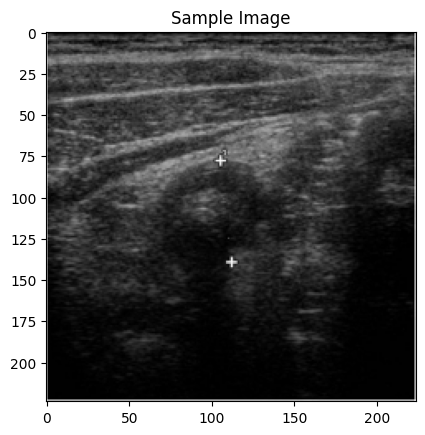

Caption shape: (128, 80)
Caption: [    3    65   838     5  2217    23     2    30    16  1178 18609     7
   682   285  1963    43     7    93   497   576     6   967    43     7
   552  1576     6  1290  1576     6  1628  1581  3053     4     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [11]:
with strategy.scope():
    class DatasetBuilder:
        def __init__(self, vectorization_layer, batch_size, img_size, autotune=tf.data.AUTOTUNE):
            self.vectorization_layer = vectorization_layer
            self.batch_size = batch_size
            self.img_size = img_size
            self.autotune = autotune

        def decode_and_resize(self, img_path):
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.img_size)
            img = tf.cast(img, tf.float32) / 255.0
            return img

        def process_input(self, img_path, caption):
            img = self.decode_and_resize(img_path)
            caption = tf.expand_dims(caption, 0)
            caption = self.vectorization_layer(caption)
            return img, tf.squeeze(caption, 0)

        def make_dataset(self, image_paths, captions):
            dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
            dataset = dataset.shuffle(buffer_size=len(image_paths))
            dataset = dataset.map(self.process_input, num_parallel_calls=self.autotune)
            dataset = dataset.batch(self.batch_size).prefetch(self.autotune)
            return dataset


    dataset_builder = DatasetBuilder(vectorization,BATCH_SIZE,IMAGE_SIZE)

    # Assuming 'train_data', 'valid_data', and 'test_data' are available
    train_dataset = dataset_builder.make_dataset(list(train_data.keys()), list(train_data.values()))
    valid_dataset = dataset_builder.make_dataset(list(valid_data.keys()), list(valid_data.values()))
    test_dataset = dataset_builder.make_dataset(list(test_data.keys()), list(test_data.values()))

    # To print example data
    for img, caption in train_dataset.take(1):
        print("Image shape:", img.numpy().shape)

        # Display the first image in the batch
        plt.imshow(img.numpy()[0])
        plt.title("Sample Image")
        plt.show()

        print("Caption shape:", caption.numpy().shape)
        print("Caption:", caption.numpy()[0])

#### 6. Dense121 with ChexNet Weights for Extracting Image Features

In [12]:
chexnet_weights = "brucechou1983_CheXNet_Keras_0.3.0_weights.h5"

with strategy.scope():
    def get_cnn_model():
        base_model = DenseNet121(include_top=False, input_shape=(*IMAGE_SIZE, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(14, activation="sigmoid", name="chexnet_output")(x)
        chexnet = tf.keras.Model(inputs = base_model.input,outputs = x)
        chexnet.load_weights(chexnet_weights)
        x = chexnet.get_layer('relu').output
        x = Conv2D(2048, (1, 1), padding='same', activation='relu')(x)
        x = Reshape((49, 2048))(x)
        cnn_model = tf.keras.Model(inputs=base_model.input, outputs=x)
        return cnn_model
#cnn_model.summary()

# for layer in base_model.layers:
#     layer.trainable = False
# for layer in cnn_model.layers:
#     print(layer.name, layer.trainable)

#### 7. Transformer Encoder Block

In [13]:
with strategy.scope():
    class TransformerEncoderBlock(layers.Layer):
        def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
            super().__init__(**kwargs)
            self.embed_dim = embed_dim
            self.dense_dim = dense_dim
            self.num_heads = num_heads
            self.attention_1 = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=embed_dim, dropout=0.0
            )
            self.layernorm_1 = layers.LayerNormalization()
            self.layernorm_2 = layers.LayerNormalization()
            self.dense_1 = layers.Dense(embed_dim, activation="relu")

        def call(self, inputs, training, mask=None):
            #print("Encoder input shape:", tf.shape(inputs))
            inputs = self.layernorm_1(inputs)
            inputs = self.dense_1(inputs)

            attention_output_1 = self.attention_1(
                query=inputs,
                value=inputs,
                key=inputs,
                attention_mask=None,
                training=training,
            )
            out_1 = self.layernorm_2(inputs + attention_output_1)
            #print("Encoder output shape:", tf.shape(out_1))
            return out_1

#### 8. Positional Encoding

In [14]:
with strategy.scope():
    class PositionalEmbedding(layers.Layer):
        def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
            super().__init__(**kwargs)
            self.token_embeddings = layers.Embedding(
                input_dim=vocab_size, output_dim=embed_dim
            )
            self.position_embeddings = layers.Embedding(
                input_dim=sequence_length, output_dim=embed_dim
            )
            self.sequence_length = sequence_length
            self.vocab_size = vocab_size
            self.embed_dim = embed_dim
            self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

        def call(self, inputs):
            #print("Positional Embedding input shape:", tf.shape(inputs))
            length = tf.shape(inputs)[-1]
            positions = tf.range(start=0, limit=length, delta=1)
            embedded_tokens = self.token_embeddings(inputs)
            embedded_tokens = embedded_tokens * self.embed_scale
            embedded_positions = self.position_embeddings(positions)
            final_embeddings = embedded_tokens + embedded_positions

            # Checking the shape of the output tensor
            #print("Positional Embedding Output shape:", tf.shape(final_embeddings))

            return final_embeddings

        def compute_mask(self, inputs, mask=None):
            return tf.math.not_equal(inputs, 0)

#### 9. Transformer Decoder Block

In [15]:
with strategy.scope():
    class TransformerDecoderBlock(layers.Layer):
        def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
            super().__init__(**kwargs)
            self.embed_dim = embed_dim
            self.ff_dim = ff_dim
            self.num_heads = num_heads
            self.attention_1 = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=embed_dim, dropout=0.1
            )
            self.attention_2 = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=embed_dim, dropout=0.1
            )
            self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
            self.ffn_layer_2 = layers.Dense(embed_dim)

            self.layernorm_1 = layers.LayerNormalization()
            self.layernorm_2 = layers.LayerNormalization()
            self.layernorm_3 = layers.LayerNormalization()

            self.embedding = PositionalEmbedding(
                embed_dim=EMBED_DIM,
                sequence_length=SEQ_LENGTH,
                vocab_size=VOCAB_SIZE,
            )
            self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

            self.dropout_1 = layers.Dropout(0.3)
            self.dropout_2 = layers.Dropout(0.5)
            self.supports_masking = True

        def call(self, inputs, encoder_outputs, training, mask=None):
            # Print input shapes
            #print("Decoder input shape:", tf.shape(inputs))
            #print("Encoder output shape:", tf.shape(encoder_outputs))
            inputs = self.embedding(inputs)
            #print("Shape after embedding in Decoder Block:", tf.shape(inputs))
            causal_mask = self.get_causal_attention_mask(inputs)

            if mask is not None:
                padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
                combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
                combined_mask = tf.minimum(combined_mask, causal_mask)

            attention_output_1 = self.attention_1(
                query=inputs,
                value=inputs,
                key=inputs,
                attention_mask=combined_mask,
                training=training,
            )
            out_1 = self.layernorm_1(inputs + attention_output_1)
            #print("Shape after first attention:", tf.shape(out_1))

            attention_output_2 = self.attention_2(
                query=out_1,
                value=encoder_outputs,
                key=encoder_outputs,
                attention_mask=padding_mask,
                training=training,
            )
            out_2 = self.layernorm_2(out_1 + attention_output_2)
            #print("Shape after second attention:", tf.shape(out_2))
            ffn_out = self.ffn_layer_1(out_2)
            ffn_out = self.dropout_1(ffn_out, training=training)
            ffn_out = self.ffn_layer_2(ffn_out)

            ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
            ffn_out = self.dropout_2(ffn_out, training=training)
            preds = self.out(ffn_out)
            #print("Decoder final output shape:", tf.shape(preds))
            return preds

        def get_causal_attention_mask(self, inputs):
            input_shape = tf.shape(inputs)
            batch_size, sequence_length = input_shape[0], input_shape[1]
            i = tf.range(sequence_length)[:, tf.newaxis]
            j = tf.range(sequence_length)
            mask = tf.cast(i >= j, dtype="int32")
            mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
            mult = tf.concat(
                [
                    tf.expand_dims(batch_size, -1),
                    tf.constant([1, 1], dtype=tf.int32),
                ],
                axis=0,
            )
            return tf.tile(mask, mult)

#### 10. Image Captioning Model

In [16]:
with strategy.scope():
    class ImageCaptioningModel(keras.Model):
        def __init__(
            self,
            cnn_model,
            encoder,
            decoder,
            image_aug=None,
        ):
            super().__init__()
            self.cnn_model = cnn_model
            self.encoder = encoder
            self.decoder = decoder
            self.loss_tracker = keras.metrics.Mean(name="loss")
            self.acc_tracker = keras.metrics.Mean(name="accuracy")
            self.image_aug = image_aug

        def calculate_loss(self, y_true, y_pred, mask):
            loss = self.loss(y_true, y_pred)
            mask = tf.cast(mask, dtype=loss.dtype)
            loss *= mask
            return tf.reduce_sum(loss) / tf.reduce_sum(mask)

        def calculate_accuracy(self, y_true, y_pred, mask):
            accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
            accuracy = tf.math.logical_and(mask, accuracy)
            accuracy = tf.cast(accuracy, dtype=tf.float32)
            mask = tf.cast(mask, dtype=tf.float32)
            return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

        def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
            # Process a single caption per image
            encoder_out = self.encoder(img_embed, training=training)
            batch_seq_inp = batch_seq[:, :-1]
            batch_seq_true = batch_seq[:, 1:]
            mask = tf.math.not_equal(batch_seq_true, 0)
            batch_seq_pred = self.decoder(
                batch_seq_inp, encoder_out, training=training, mask=mask
            )
            loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
            acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
            #print("Shape of encoder output:", tf.shape(encoder_out))
            #print("Shape of predicted sequence:", tf.shape(batch_seq_pred))
            return loss, acc

        def train_step(self, batch_data):
            batch_img, batch_seq = batch_data

            # Print shapes of inputs
            #print("Shape of batch_img:", tf.shape(batch_img))
            #print("Shape of batch_seq:", tf.shape(batch_seq))

            if self.image_aug:
                batch_img = self.image_aug(batch_img)
            img_embed = self.cnn_model(batch_img)
            #print("Shape of img_embed:", tf.shape(img_embed))
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq, training=True
                )
                self.loss_tracker.update_state(loss)
                self.acc_tracker.update_state(acc)

            train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

            return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

        def test_step(self, batch_data):
            batch_img, batch_seq = batch_data
            # Print shapes of inputs
            #print("Shape of batch_img (test):", tf.shape(batch_img))
            #print("Shape of batch_seq (test):", tf.shape(batch_seq))
            img_embed = self.cnn_model(batch_img)
            #print("Shape of img_embed (test):", tf.shape(img_embed))
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq, training=False
            )
            self.loss_tracker.update_state(loss)
            self.acc_tracker.update_state(acc)
            return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
        @property
        def metrics(self):
            # We need to list our metrics here so the `reset_states()` can be
            # called automatically.
            return [self.loss_tracker, self.acc_tracker]

#### 11. Building Final Model

In [17]:
with strategy.scope():
    cnn_model = get_cnn_model()
    encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
    decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
    caption_model = ImageCaptioningModel(
        cnn_model=cnn_model,
        encoder=encoder,
        decoder=decoder,
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [20]:
with strategy.scope():

    # Define the loss function
    cross_entropy = keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE,
    )

    # EarlyStopping criteria
    early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    

    # Learning Rate Scheduler for the optimizer
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, post_warmup_learning_rate, warmup_steps):
            super().__init__()
            self.post_warmup_learning_rate = post_warmup_learning_rate
            self.warmup_steps = warmup_steps

        def __call__(self, step):
            global_step = tf.cast(step, tf.float32)
            warmup_steps = tf.cast(self.warmup_steps, tf.float32)
            warmup_progress = global_step / warmup_steps
            warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
            return tf.cond(
                global_step < warmup_steps,
                lambda: warmup_learning_rate,
                lambda: self.post_warmup_learning_rate,
            )


    # Create a learning rate schedule
    num_train_steps = len(train_dataset) * EPOCHS
    num_warmup_steps = num_train_steps // 15
    lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

    # Compile the model
    caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [28]:
with strategy.scope():

    # Define the loss function
    cross_entropy = keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE,
    )

    # EarlyStopping criteria
    early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    

    # Learning Rate Scheduler for the optimizer
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, post_warmup_learning_rate, warmup_steps):
            super().__init__()
            self.post_warmup_learning_rate = post_warmup_learning_rate
            self.warmup_steps = warmup_steps

        def __call__(self, step):
            global_step = tf.cast(step, tf.float32)
            warmup_steps = tf.cast(self.warmup_steps, tf.float32)
            warmup_progress = global_step / warmup_steps
            warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
            return tf.cond(
                global_step < warmup_steps,
                lambda: warmup_learning_rate,
                lambda: self.post_warmup_learning_rate,
            )


    # Create a learning rate schedule
    num_train_steps = len(train_dataset) * EPOCHS
    num_warmup_steps = num_train_steps // 15
    lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

    # Compile the model
    caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

#### 12. Training the Final Model

In [21]:
with strategy.scope():
    history = caption_model.fit(
        train_dataset,
        epochs=200,
        validation_data=valid_dataset,
        #callbacks=[early_stopping],
    )

2024-05-03 12:16:23.800250: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 64064
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:15"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
   

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').


2024-05-03 12:16:43.677671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-05-03 12:16:43.698450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-05-03 12:16:45.827776: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ff9a8069800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 12:16:45.827821: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-03 12:16:45.827831: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-03 12:16:45.870827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 12:16:46.297360: I tensorflow/compiler/jit/xla_compilation_cache.cc:477

501/501 [==============================] - ETA: 0s - loss: 8.7919 - acc: 0.0315

2024-05-03 12:20:54.274813: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 12012
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:20"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
   

501/501 [==============================] - 323s 595ms/step - loss: 8.7919 - acc: 0.0315 - val_loss: 6.7319 - val_acc: 0.0710
Epoch 2/200
501/501 [==============================] - 223s 444ms/step - loss: 6.2872 - acc: 0.1077 - val_loss: 5.7813 - val_acc: 0.1845
Epoch 3/200
501/501 [==============================] - 223s 444ms/step - loss: 5.5042 - acc: 0.1958 - val_loss: 5.2088 - val_acc: 0.2367
Epoch 4/200
501/501 [==============================] - 223s 445ms/step - loss: 5.0284 - acc: 0.2427 - val_loss: 4.8698 - val_acc: 0.2612
Epoch 5/200
501/501 [==============================] - 221s 440ms/step - loss: 4.7209 - acc: 0.2641 - val_loss: 4.6498 - val_acc: 0.2754
Epoch 6/200
501/501 [==============================] - 222s 443ms/step - loss: 4.5000 - acc: 0.2791 - val_loss: 4.5024 - val_acc: 0.2857
Epoch 7/200
501/501 [==============================] - 220s 439ms/step - loss: 4.3316 - acc: 0.2886 - val_loss: 4.4067 - val_acc: 0.2917
Epoch 8/200
501/501 [==============================] 

#### 13. Loss and Accuracy Presentation

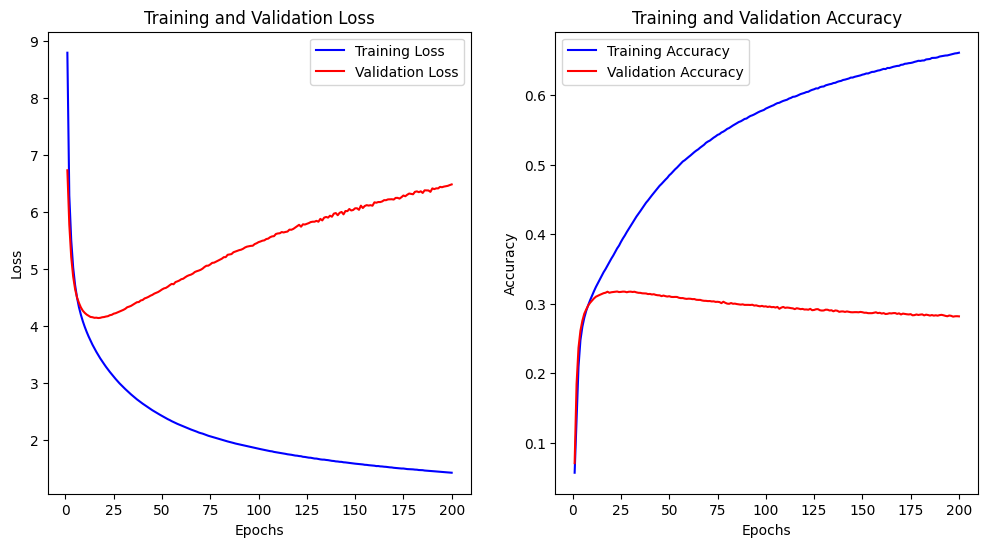

In [22]:
# Extracting loss and other metrics from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Update these lines with the correct keys
acc = history.history['acc']  # Assuming 'acc' is the correct key for accuracy
val_acc = history.history['val_acc']  # And 'val_acc' for validation accuracy

epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 14. Test Dataset Predicted Outputs based on Greedy Search

Image shape: (224, 224, 3)


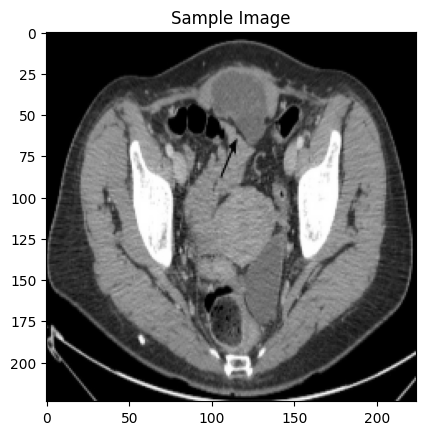

Image shape after reshaping: (1, 224, 224, 3)
Caption shape: (80,)
Caption Tokens: [   3    7  219 1624 3876   27  172   73    9  395 1588   19 1204    8
    2  862  148    5    2   46    8    2 3383   94   13    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Ground Truth Caption: <start> a solid poorly vascularized mass measuring mm with thin septa is apparent in the rectus muscle of the abdomen in the suprapubic area arrow <end>
Predicted Caption: ct scan of the abdomen showing a large mass in the right rectus muscle with surrounding fat stranding of the rectus muscle red arrow and subcutaneous fat stranding of the muscles in this case


In [23]:
for img, caption in test_dataset.take(1):
    sample_img = img.numpy()[0]
    print("Image shape:", sample_img.shape)
    plt.imshow(sample_img)
    plt.title("Sample Image")
    plt.show()
    image = tf.expand_dims(sample_img, 0)
    print("Image shape after reshaping:", image.shape)
    cnn_img = caption_model.cnn_model(image)
    encoded_img = caption_model.encoder(cnn_img, training=False)

    vocab = vectorization.get_vocabulary()
    index_lookup = dict(zip(range(len(vocab)), vocab))
    max_decoded_sentence_length = SEQ_LENGTH - 1

    sample_cap = caption.numpy()[0]
    print("Caption shape:", sample_cap.shape)
    print("Caption Tokens:", sample_cap)
    
    # Convert each token in sample_cap to the corresponding word and join them
    actual_caption = " ".join([index_lookup.get(token, '') for token in sample_cap if token != 0])
    print("Ground Truth Caption:", actual_caption)

    decoded_caption = "<start> "

    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption:", decoded_caption)

In [37]:
type(test_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [41]:
#ls ../Test

In [51]:
test_path = '../Test/'
test_path_list = os.listdir(test_path)

len(test_path_list)

17238

In [52]:
test_path_list.sort()

In [55]:
#len(test_path_list)
test_path_list[0]

'ImageCLEFmedical_Caption_2024_test_000001.jpg'

In [53]:
test_paths_enc = []

In [56]:
#os.path.join(test_path,dir_list[6])

ext = ('jpg','png')
#for i in tqdm(range(int(len(dir_list)))):
for i in tqdm(range(len(test_path_list))):
    new_test_path = os.path.join(test_path, test_path_list[i])
    #print(new_test_path)
    if new_test_path.endswith(ext):
        #print(new_test_path)  # printing file name of desired extension
        test_paths_enc.append(new_test_path)
    else:
        continue

100%|██████████| 17238/17238 [00:00<00:00, 589734.20it/s]


In [57]:
len(test_paths_enc)

17237

In [61]:
import cv2

In [75]:
from tqdm import tqdm

predicted_captions = []
actual_captions = []


# Assuming test_dataset is a tf.data.Dataset and each element is a tuple (image, caption, image_id)
for img in tqdm(test_paths_enc, desc="Processing Test Dataset"):
    img = cv2.imread(img)
    #print(img.shape)
    #for idx in range(img.shape[0]):  # Loop through the batch
    #print(img.shape)
    #sample_img = img.numpy()[idx]
    #image = tf.expand_dims(sample_img, 0)
    image_tensor = tf.convert_to_tensor(img)
    resized_images = tf.image.resize_with_pad(image_tensor, target_height=224, target_width=224)
    #print(resized_images.shape)
    image = tf.expand_dims(resized_images, 0)
    # Ensure the data type is float32 and values are in the range [0, 1]
    #resized_image = tf.cast(resized_image, tf.float32) / 255.0

    #resize_image = img.reshape([-1, 224, 224, 3])
    cnn_img = caption_model.cnn_model(image)
    encoded_img = caption_model.encoder(cnn_img, training=False)

    vocab = vectorization.get_vocabulary()
    index_lookup = dict(zip(range(len(vocab)), vocab))
    max_decoded_sentence_length = SEQ_LENGTH - 1

    #sample_cap = caption.numpy()[idx]
    #actual_caption = " ".join([index_lookup.get(token, '') for token in sample_cap if token != 0]).replace("<start>", "").replace("<end>", "").strip()
    #actual_captions.append(actual_caption)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "").replace("<end>", "").strip()
    predicted_captions.append(decoded_caption)

Processing Test Dataset: 100%|██████████| 17237/17237 [11:13:50<00:00,  2.35s/it]  


In [76]:
import pandas as pd

In [77]:
enc_dec_caption_df = pd.DataFrame(predicted_captions)

In [78]:
enc_dec_caption_df.shape

(17237, 1)

In [79]:
enc_dec_caption_df.tail()

,0
17232,chest chest chest ct scan showing increased si...
17233,a chest x ray image saggital chest showing low...
17234,chest x cm in dimension in thickness noise dim...
17235,in frontal frontal frontal frontal frontal fro...
17236,in sagital sagital sagital sagital sagital sag...


In [80]:
enc_dec_caption_csv = enc_dec_caption_df.to_csv('enc_dec_caption.csv')

#### 15. Evaluation Metric

In [30]:
def get_bleu(reference,prediction):
    """
    Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
    """
    reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
    prediction = prediction.split()
    bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0))
    bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
    bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
    bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

    return bleu1,bleu2,bleu3,bleu4

In [31]:
from nltk.translate.bleu_score import sentence_bleu
def mean_bleu(pred_ls, act_ls, **kwargs):

    bleu1, bleu2, bleu3, bleu4 = [], [], [], []

    for k in range (len(pred_ls)):
        # Tokenize the true and predicted captions
        true_tokens = act_ls[k]
        #print ("True: ",true_tokens)
        predict_tokens = pred_ls[k]
        #print ("Predicted: ",predict_tokens)
        
        # Calculate BLEU scores
        bleu1.append(sentence_bleu([true_tokens], predict_tokens, weights=(1, 0, 0, 0)))
        bleu2.append(sentence_bleu([true_tokens], predict_tokens, weights=(0.5, 0.5, 0, 0)))
        bleu3.append(sentence_bleu([true_tokens], predict_tokens, weights=(0.33, 0.33, 0.33, 0)))
        bleu4.append(sentence_bleu([true_tokens], predict_tokens, weights=(0.25, 0.25, 0.25, 0.25)))

    return np.array(bleu1).mean(), np.array(bleu2).mean(), np.array(bleu3).mean(), np.array(bleu4).mean()
bleu1,bleu2,bleu3,bleu4 = mean_bleu(predicted_captions,actual_captions)
print ("Bleu Score 1-gram: ",bleu1)
print ("Bleu Score 2-gram: ",bleu2)
print ("Bleu Score 3-gram: ",bleu3)
print ("Bleu Score 4-gram: ",bleu4)

Bleu Score 1-gram:  0.4642178044685795
Bleu Score 2-gram:  0.3497622807893795
Bleu Score 3-gram:  0.2570667159834576
Bleu Score 4-gram:  0.19584624364798942


In [32]:
from rouge import Rouge

def calculate_rouge_scores(predictions, references):
    rouge = Rouge()
    scores = rouge.get_scores(predictions, references, avg=True)
    return scores

rouge_scores = calculate_rouge_scores(predicted_captions, actual_captions)
print(rouge_scores)

ModuleNotFoundError: No module named 'rouge'

    ROUGE-1:
        r: 19.85% (This means 19.85% of the words in the reference appear in the generated text)
        p: 26.59% (This means 26.59% of the words in the generated text are also in the reference)
        f: 21.08% (This is the F1-score, balancing precision and recall for unigrams)

    ROUGE-2:
        r: 6.10% (Lower recall for bigrams suggests less exact matches of word pairs)
        p: 8.59% (Precision for bigrams is also lower, indicating less exact pairings of words)
        f: 6.47% (The F1-score for bigrams is significantly lower than for unigrams)

    ROUGE-L:
        r: 18.00% (Recall for the longest common subsequence)
        p: 23.81% (Precision for the longest common subsequence)
        f: 18.98% (F1-score for the longest common subsequence)

In [27]:
from nltk.translate.meteor_score import meteor_score
import numpy as np

# Tokenize the captions
# Assuming actual_captions and predicted_captions are lists of strings
actual_captions_tokenized = [[act.split()] for act in actual_captions]  # List of lists of lists for references
predicted_captions_tokenized = [pred.split() for pred in predicted_captions]  # List of lists for hypothesis

# Calculate METEOR scores
meteor_scores = [meteor_score(ref, pred) for ref, pred in zip(actual_captions_tokenized, predicted_captions_tokenized)]
mean_meteor_score = np.mean(meteor_scores)

print(f"Mean METEOR score: {mean_meteor_score}")

Mean METEOR score: 0.143703338938896


#### 16. XAI